***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
    

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import copy

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df_html=pd.read_csv('HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)

df_html.head()

Shape of our dataset: (43491, 1461)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async

In [12]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)

print("Shape of our dataset:",df_js.shape)

df_js.head()

Shape of our dataset: (43294, 401)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [13]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

In [14]:
print("{} columns in JavaScript experiment with all missing or only one unique value".format(len(col_js_no_uni)))
print("{} columns in HTML experiment with all missing or only one unique value".format(len(col_html_no_uni)))

113 columns in JavaScript experiment with all missing or only one unique value
0 columns in HTML experiment with all missing or only one unique value


In [15]:
df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

In [16]:
print("Shape of JavaScript experiemtn after dropping them:",df_js.shape)
print("Shape of HTML experiemtn after dropping them:",df_html.shape)

Shape of JavaScript experiemtn after dropping them: (43294, 288)
Shape of HTML experiemtn after dropping them: (43491, 1461)


In [17]:
col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)
print("{} columns in JavaScript experiment with more than 95% same values".format(len(col_js_95[col_js_95['95_%_same_values']==True])))
print("{} columns in HTML experiment with more than 95% same values".format(len(col_html_95[col_html_95['95_%_same_values']==True])))

234 columns in JavaScript experiment with more than 95% same values
1297 columns in HTML experiment with more than 95% same values


In [18]:
### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of JavaScript experiment after dropping them:",df_js.shape)
print("Shape of HTML experiment after dropping them:",df_html.shape)

Shape of JavaScript experiment after dropping them: (43294, 54)
Shape of HTML experiment after dropping them: (43491, 164)


#### Let us analyze the balance of classes

In [19]:
class_bal(df_js,'JavaScript experiment')
class_bal(df_html,'HTML experiment')

#### Analyzing the categorical and numerical features

In [20]:
cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

In [21]:
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_js,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_js,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
js_function_.split(,-0.097541,5.300145e-92,-46.252895,0.000000e+00
js_function_Math.random(,-0.094978,2.620317e-87,-44.513654,0.000000e+00
js_function_.setTime(,-0.083818,2.410642e-68,-41.813198,0.000000e+00
js_function_.replace(,-0.087844,6.536777e-75,-38.924200,0.000000e+00
js_function_.indexOf(,-0.075600,6.618535e-56,-36.469099,9.453374e-287



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [22]:
print("Stats for numerical features for HTML experiment\n")
num_stats_html=num_stats(df_html,num_var_html)
display(num_stats_html)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_html=cat_stats(df_html,cat_var_html)
display(cat_stats_html)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_absolute,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [23]:
fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [24]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [25]:
print("Features we will be using:")
display(fin_col)

Features we will be using:


['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_relative',
 'a_href_absolute

In [26]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

In [27]:
columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [28]:
class_bal(df_sel,'Combined experiments')

In [29]:
### Preparing our training and test sets
X=df_sel.iloc[:,df_sel.columns!='Target'].values
y=df_sel.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [35]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [31]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [32]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.89645960635
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24923  2939    27862
True         433  4272     4705
__all__    25356  7211    32567

Accuracy of the KNN model for twst data is: 0.894497666421
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6178   738     6916
True         121  1105     1226
__all__     6299  1843     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.855006601775
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27785    77    27862
True        4645    60     4705
__all__    32430   137    32567

Accuracy of the Logistic Regression model for twst data is: 0.849422746254
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6893    23     6916
True        1203    23     1226
__all__     8096    46     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.908250683207
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24989  2873    27862
True         115  4590     4705
__all__    25104  7463    32567

Accuracy of the Random Forest Classifier for twst data is: 0.89756816507
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6194   722     6916
True         112  1114     1226
__all__     6306  1836     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.875886633709
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24647  3215    27862
True         827  3878     4705
__all__    25474  7093    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.877057234095
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6124   792     6916
True         209  1017     1226
__all__     6333  1809     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.893634660853
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24980  2882    27862
True         582  4123     4705
__all__    25562  7005    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.89240972734
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6195   721     6916
True         155  1071     1226
__all__     6350  1792     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.910215862683
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24998  2864    27862
True          60  4645     4705
__all__    25058  7509    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.897445345124
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6194   722     6916
True         113  1113     1226
__all__     6307  1835     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.908066447631
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24987  2875    27862
True         119  4586     4705
__all__    25106  7461    32567

Accuracy of the Bagging model for twst data is: 0.896217145664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6176   740     6916
True         105  1121     1226
__all__     6281  1861     8142



Neural Network-1
The accuracy of the model on training data is: 0.894340897242


Predicted  False  True  __all__
Actual                         
False      24708  3154    27862
True         287  4418     4705
__all__    24995  7572    32567

The accuracy of the model on test data is: 0.885286170474


Predicted  False  True  __all__
Actual                         
False       6103   813     6916
True         121  1105     1226
__all__     6224  1918     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [33]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [34]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.896460,4272.0,24923.0,2939.0,433.0,0.105484,0.092030
LogisticRegression,0.855007,60.0,27785.0,77.0,4645.0,0.002764,0.987248
RandomForestClassifier,0.908251,4590.0,24989.0,2873.0,115.0,0.103115,0.024442
AdaBoostClassifier,0.875887,3878.0,24647.0,3215.0,827.0,0.115390,0.175770
GradientBoostingClassifier,0.893635,4123.0,24980.0,2882.0,582.0,0.103438,0.123698
ExtraTreeClassifier,0.910216,4645.0,24998.0,2864.0,60.0,0.102792,0.012752
BaggingClassifier,0.908066,4586.0,24987.0,2875.0,119.0,0.103187,0.025292
Neural Network-1,0.894341,4418.0,24708.0,3154.0,287.0,0.113201,0.060999


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.894498,1105.0,6178.0,738.0,121.0,0.106709,0.098695,0.897298
LogisticRegression,0.849423,23.0,6893.0,23.0,1203.0,0.003326,0.981240,0.507717
RandomForestClassifier,0.897568,1114.0,6194.0,722.0,112.0,0.104396,0.091354,0.902125
AdaBoostClassifier,0.877057,1017.0,6124.0,792.0,209.0,0.114517,0.170473,0.857505
GradientBoostingClassifier,0.892410,1071.0,6195.0,721.0,155.0,0.104251,0.126427,0.884661
ExtraTreeClassifier,0.897445,1113.0,6194.0,722.0,113.0,0.104396,0.092170,0.901717
BaggingClassifier,0.896217,1121.0,6176.0,740.0,105.0,0.106998,0.085644,0.903679
Neural Network-1,0.885286,1105.0,6103.0,813.0,121.0,0.117553,0.098695,0.903679


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [35]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [36]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [37]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 40709, Columns: 51]
  Relationships:
    No relationships

In [38]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 7.291 seconds
Elapsed: 00:46 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [39]:
feature_matrix_sessions.head()

,dom_function_document.getElementsByTagName(,dom_function_document.createElement(,js_function_.getTime(,dom_function_window.addEventListener(,js_function_.split(,js_function_Math.random(,js_function_.setTime(,js_function_.replace(,js_function_.indexOf(,js_function_Math.floor(,js_function_decodeURIComponent(,js_function_.match(,js_function_JSON.parse(,js_function_.pop(,js_function_.charAt(,js_function_.concat(,js_function_encodeURIComponent(,js_function_.test(,js_function_.apply(,js_function_.substr,js_function_Math.round(,js_function_.substring(,js_function_.shift(,js_function_.join(,js_function_.push(,script_src_.js,script_count,script_src_relative,script_src_absolute,script_src_https,script_async_true,link_rel_canonical,div_count,script_type_text/javascript,script_src_out_of_domain,iframe_count,a_count,a_href_relative,a_href_absolute,a_href_out_of_domain,img_count,meta_http-equiv_X-UA-Compatible,link_href_https,img_src_relative,img_src_absolute,img_src_https,iframe_src_absolute,iframe_src_relative,link_rel_shortcut icon,iframe_src_https,script_src_absolute + script_src_relative,iframe_src_relative + js_function_.substr,a_href_relative + script_src_.js,iframe_src_https + js_function_.apply(,a_href_out_of_domain + dom_function_document.getElementsByTagName(,js_function_.charAt( + script_src_.js,dom_function_window.addEventListener( + script_async_true,a_count + js_function_Math.floor(,js_function_.apply( + js_function_.indexOf(,js_function_.charAt( + script_src_https,js_function_.concat( + js_function_encodeURIComponent(,img_src_absolute + script_src_relative,js_function_Math.floor( + link_rel_shortcut icon,div_count + js_function_.test(,div_count + js_function_.replace(,script_src_absolute + script_type_text/javascript,iframe_src_relative + img_src_absolute,js_function_.apply( + link_href_https,iframe_src_absolute + js_function_.pop(,div_count + iframe_src_relative,js_function_JSON.parse( + link_href_https,iframe_count + js_function_.join(,a_count + meta_http-equiv_X-UA-Compatible,script_src_.js + script_src_absolute,js_function_decodeURIComponent( + script_src_.js,js_function_.substring( + meta_http-equiv_X-UA-Compatible,dom_function_window.addEventListener( + js_function_decodeURIComponent(,iframe_count + meta_http-equiv_X-UA-Compatible,img_src_absolute + js_function_.replace(,div_count + iframe_count,iframe_src_https + js_function_.charAt(,js_function_.substring( + script_src_https,js_function_.substr + link_rel_canonical,js_function_.pop( + script_src_out_of_domain,iframe_src_absolute + iframe_src_relative,js_function_.push( + script_src_relative,iframe_count + js_function_.substring(,iframe_count + js_function_JSON.parse(,img_src_https + js_function_.setTime(,js_function_.getTime( + js_function_.split(,js_function_.pop( + js_function_decodeURIComponent(,js_function_.getTime( + meta_http-equiv_X-UA-Compatible,js_function_.concat( + script_src_.js,js_function_.indexOf( + js_function_Math.random(,dom_function_window.addEventListener( + js_function_Math.round(,img_src_https + js_function_.test(,js_function_.getTime( + script_src_https,link_href_https + link_rel_shortcut icon,dom_function_window.addEventListener( + js_function_.pop(,js_function_.setTime( + meta_http-equiv_X-UA-Compatible,js_function_.join( + link_href_https,js_function_.setTime( + script_async_true,a_href_out_of_domain + js_function_.pop(,js_function_.pop( + js_function_.setTime(,iframe_src_https + script_src_out_of_domain,js_function_Math.random( + link_rel_shortcut icon,img_src_https + js_function_decodeURIComponent(,img_src_absolute + script_src_https,dom_function_document.getElementsByTagName( + iframe_src_relative,img_count + js_function_.join(,dom_function_document.getElementsByTagName( + js_function_.test(,a_href_relative + js_function_Math.random(,js_function_Math.floor( + script_src_out_of_domain,img_src_https + script_src_out_of_domain,js_function_.concat( + js_function_.substr,dom_function_document.createElement( + js_function_.indexOf(,js_function

In [40]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [44]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [45]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [46]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [71]:
X=fs[feature_selection_df[feature_selection_df.Total>=2]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 85)

In [72]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_absolute / script_src_relative',
 'script_src_.js / script_src_relative',
 'script_count + script_src_.js',
 'script_async_true / script_count',
 'link_rel_shortcut icon + script_src_.js',
 'link_rel_shortcut icon + meta_http-equiv_X-UA-Compatible',
 'link_rel_canonical + link_rel_shortcut icon',
 'a_href_out_of_domain / a_href_relative',
 'script_type_text/javascript / script_count',
 'script_src_relative / script_src_absolute',
 'script_src_relative / script_count',
 'script_src_out_of_domain / script_src_relative',
 'script_src_out_of_domain / script_src_absolute',
 'script_src_out_of_domain / script_count',
 'script_src_https / script_src_relative',
 'script_src_https / script_src_absolute',
 'script_src_https / script_count',
 'script_src_absolute / script_count',
 'script_src_.js / script_src_absolute',
 'script_src_.js / script_count',
 'script_src_.js',
 'script_count / script_src_relative',
 'script_count + script_src_relative',
 'script_count + script_src_absolut

In [73]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [74]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.89332760156
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24742  3063    27805
True         411  4351     4762
__all__    25153  7414    32567

Accuracy of the KNN model for twst data is: 0.888356669123
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6191   782     6973
True         127  1042     1169
__all__     6318  1824     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.881045229834
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24699  3106    27805
True         768  3994     4762
__all__    25467  7100    32567

Accuracy of the Logistic Regression model for twst data is: 0.880127732744
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   787     6973
True         189   980     1169
__all__     6375  1767     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.902999969294
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24772  3033    27805
True         126  4636     4762
__all__    24898  7669    32567

Accuracy of the Random Forest Classifier for twst data is: 0.89118152788
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6199   774     6973
True         112  1057     1169
__all__     6311  1831     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.881874289925
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24566  3239    27805
True         608  4154     4762
__all__    25174  7393    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.879513633014
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6152   821     6973
True         160  1009     1169
__all__     6312  1830     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.889642890042
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24817  2988    27805
True         606  4156     4762
__all__    25423  7144    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.887128469663
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6218   755     6973
True         164  1005     1169
__all__     6382  1760     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.904903736912
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24779  3026    27805
True          71  4691     4762
__all__    24850  7717    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.891427167772
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6196   777     6973
True         107  1062     1169
__all__     6303  1839     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.90272361593
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24772  3033    27805
True         135  4627     4762
__all__    24907  7660    32567

Accuracy of the Bagging model for twst data is: 0.890813068042
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6197   776     6973
True         113  1056     1169
__all__     6310  1832     8142



Neural Network-1
The accuracy of the model on training data is: 0.895784075892


Predicted  False  True  __all__
Actual                         
False      24634  3171    27805
True         223  4539     4762
__all__    24857  7710    32567

The accuracy of the model on test data is: 0.886145910096


Predicted  False  True  __all__
Actual                         
False       6155   818     6973
True         109  1060     1169
__all__     6264  1878     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [75]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [76]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.893328,4351.0,24742.0,3063.0,411.0,0.110160,0.086308
LogisticRegression,0.881045,3994.0,24699.0,3106.0,768.0,0.111707,0.161277
RandomForestClassifier,0.903000,4636.0,24772.0,3033.0,126.0,0.109081,0.026459
AdaBoostClassifier,0.881874,4154.0,24566.0,3239.0,608.0,0.116490,0.127677
GradientBoostingClassifier,0.889643,4156.0,24817.0,2988.0,606.0,0.107463,0.127257
ExtraTreeClassifier,0.904904,4691.0,24779.0,3026.0,71.0,0.108829,0.014910
BaggingClassifier,0.902724,4627.0,24772.0,3033.0,135.0,0.109081,0.028349
Neural Network-1,0.895784,4539.0,24634.0,3171.0,223.0,0.114044,0.046829


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.888357,1042.0,6191.0,782.0,127.0,0.112147,0.108640,0.889607
LogisticRegression,0.880128,980.0,6186.0,787.0,189.0,0.112864,0.161677,0.862730
RandomForestClassifier,0.891182,1057.0,6199.0,774.0,112.0,0.111000,0.095808,0.896596
AdaBoostClassifier,0.879514,1009.0,6152.0,821.0,160.0,0.117740,0.136869,0.872696
GradientBoostingClassifier,0.887128,1005.0,6218.0,755.0,164.0,0.108275,0.140291,0.875717
ExtraTreeClassifier,0.891427,1062.0,6196.0,777.0,107.0,0.111430,0.091531,0.898519
BaggingClassifier,0.890813,1056.0,6197.0,776.0,113.0,0.111286,0.096664,0.896025
Neural Network-1,0.886146,1060.0,6155.0,818.0,109.0,0.117310,0.093242,0.896025


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [77]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [78]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

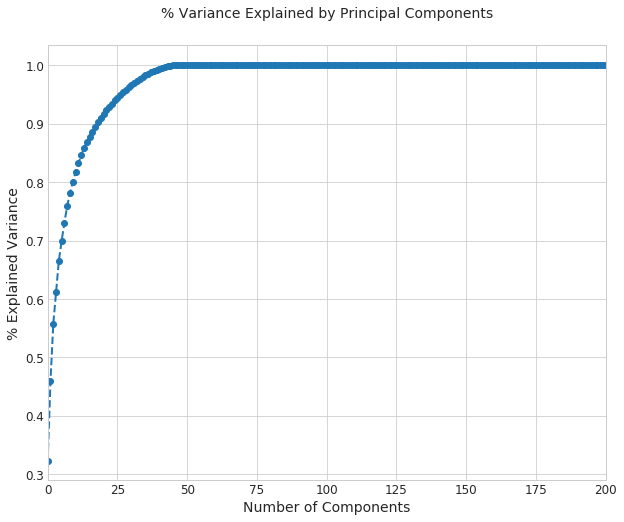

In [79]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [80]:
n=np.where(np.cumsum(pca.explained_variance_ratio_)>=0.99)[0][0]

In [81]:
pca=PCA(n_components=n,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using {} components is {}".format(n,sum(pca.explained_variance_ratio_)))

Variance explained using 38 components is 0.9878679989920679


In [82]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [83]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [84]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,n).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.87002180121
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27639   166    27805
True        4067   695     4762
__all__    31706   861    32567

Accuracy of the KNN model for twst data is: 0.866494718742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6923    50     6973
True        1037   132     1169
__all__     7960   182     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.876684987871
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24749  3056    27805
True         960  3802     4762
__all__    25709  6858    32567

Accuracy of the Logistic Regression model for twst data is: 0.877302873987
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6203   770     6973
True         229   940     1169
__all__     6432  1710     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.908281389136
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24941  2864    27805
True         123  4639     4762
__all__    25064  7503    32567

Accuracy of the Random Forest Classifier for twst data is: 0.895480225989
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6243   730     6973
True         121  1048     1169
__all__     6364  1778     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.889857831547
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24934  2871    27805
True         716  4046     4762
__all__    25650  6917    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.888111029231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6253   720     6973
True         191   978     1169
__all__     6444  1698     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.89645960635
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24974  2831    27805
True         541  4221     4762
__all__    25515  7052    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.891427167772
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6249   724     6973
True         160  1009     1169
__all__     6409  1733     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.910553627906
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24964  2841    27805
True          72  4690     4762
__all__    25036  7531    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.894988946205
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6243   730     6973
True         125  1044     1169
__all__     6368  1774     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.908373506924
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24942  2863    27805
True         121  4641     4762
__all__    25063  7504    32567

Accuracy of the Bagging model for twst data is: 0.894252026529
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6236   737     6973
True         124  1045     1169
__all__     6360  1782     8142



Neural Network-1
The accuracy of the model on training data is: 0.898854668831


Predicted  False  True  __all__
Actual                         
False      24767  3038    27805
True         256  4506     4762
__all__    25023  7544    32567

The accuracy of the model on test data is: 0.887619749447


Predicted  False  True  __all__
Actual                         
False       6183   790     6973
True         125  1044     1169
__all__     6308  1834     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [85]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [86]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.870022,695.0,27639.0,166.0,4067.0,0.005970,0.854053
LogisticRegression,0.876685,3802.0,24749.0,3056.0,960.0,0.109908,0.201596
RandomForestClassifier,0.908281,4639.0,24941.0,2864.0,123.0,0.103003,0.025829
AdaBoostClassifier,0.889858,4046.0,24934.0,2871.0,716.0,0.103255,0.150357
GradientBoostingClassifier,0.896460,4221.0,24974.0,2831.0,541.0,0.101816,0.113608
ExtraTreeClassifier,0.910554,4690.0,24964.0,2841.0,72.0,0.102176,0.015120
BaggingClassifier,0.908374,4641.0,24942.0,2863.0,121.0,0.102967,0.025409
Neural Network-1,0.898855,4506.0,24767.0,3038.0,256.0,0.109261,0.053759


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.866495,132.0,6923.0,50.0,1037.0,0.007171,0.887083,0.552873
LogisticRegression,0.877303,940.0,6203.0,770.0,229.0,0.110426,0.195894,0.846840
RandomForestClassifier,0.895480,1048.0,6243.0,730.0,121.0,0.104690,0.103507,0.895902
AdaBoostClassifier,0.888111,978.0,6253.0,720.0,191.0,0.103255,0.163388,0.866679
GradientBoostingClassifier,0.891427,1009.0,6249.0,724.0,160.0,0.103829,0.136869,0.879651
ExtraTreeClassifier,0.894989,1044.0,6243.0,730.0,125.0,0.104690,0.106929,0.894191
BaggingClassifier,0.894252,1045.0,6236.0,737.0,124.0,0.105693,0.106074,0.894117
Neural Network-1,0.887620,1044.0,6183.0,790.0,125.0,0.113294,0.106929,0.894117


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [87]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,n).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [28]:
# fin_col.remove('Target')
# columns=fin_col
print("Features we will be using:")
display(columns)

Features we will be using:


['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_relative',
 'a_href_absolute

In [29]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [36]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [38]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.929743019166
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24324   3538    27862
True         377  27485    27862
__all__    24701  31023    55724

Accuracy of the KNN model for twst data is: 0.87324981577
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5959   957     6916
True          75  1151     1226
__all__     6034  2108     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.882312827507
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22395   5467    27862
True        1091  26771    27862
__all__    23486  32238    55724

Accuracy of the Logistic Regression model for twst data is: 0.828543355441
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5568  1348     6916
True          48  1178     1226
__all__     5616  2526     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.946217069844
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24927   2935    27862
True          62  27800    27862
__all__    24989  30735    55724

Accuracy of the Random Forest Classifier for twst data is: 0.897076885286
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6166   750     6916
True          88  1138     1226
__all__     6254  1888     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895538726581
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23514   4348    27862
True        1473  26389    27862
__all__    24987  30737    55724

Accuracy of the Ada Boost Classifier for twst data is: 0.861950380742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5869  1047     6916
True          77  1149     1226
__all__     5946  2196     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.921559830594
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24268   3594    27862
True         777  27085    27862
__all__    25045  30679    55724

Accuracy of the Gradient Boosting Classifier for twst data is: 0.881724392041
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6035   881     6916
True          82  1144     1226
__all__     6117  2025     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.94698873017
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24939   2923    27862
True          31  27831    27862
__all__    24970  30754    55724

Accuracy of the Extra Tree Classifier for twst data is: 0.896585605502
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6172   744     6916
True          98  1128     1226
__all__     6270  1872     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.945750484531
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24929   2933    27862
True          90  27772    27862
__all__    25019  30705    55724

Accuracy of the Bagging model for twst data is: 0.894374846475
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6138   778     6916
True          82  1144     1226
__all__     6220  1922     8142



Neural Network-1
The accuracy of the model on training data is: 0.931573469241


Predicted  False   True  __all__
Actual                          
False      24382   3480    27862
True         333  27529    27862
__all__    24715  31009    55724

The accuracy of the model on test data is: 0.880127732744


Predicted  False  True  __all__
Actual                         
False       6012   904     6916
True          72  1154     1226
__all__     6084  2058     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [39]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [40]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.929743,27485.0,24324.0,3538.0,377.0,0.126983,0.013531
LogisticRegression,0.882313,26771.0,22395.0,5467.0,1091.0,0.196217,0.039157
RandomForestClassifier,0.946217,27800.0,24927.0,2935.0,62.0,0.105341,0.002225
AdaBoostClassifier,0.895539,26389.0,23514.0,4348.0,1473.0,0.156055,0.052868
GradientBoostingClassifier,0.921560,27085.0,24268.0,3594.0,777.0,0.128993,0.027887
ExtraTreeClassifier,0.946989,27831.0,24939.0,2923.0,31.0,0.104910,0.001113
BaggingClassifier,0.945750,27772.0,24929.0,2933.0,90.0,0.105269,0.003230
Neural Network-1,0.931573,27529.0,24382.0,3480.0,333.0,0.124901,0.011952


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.873250,1151.0,5959.0,957.0,75.0,0.138375,0.061175,0.900225
LogisticRegression,0.828543,1178.0,5568.0,1348.0,48.0,0.194910,0.039152,0.882969
RandomForestClassifier,0.897077,1138.0,6166.0,750.0,88.0,0.108444,0.071778,0.909889
AdaBoostClassifier,0.861950,1149.0,5869.0,1047.0,77.0,0.151388,0.062806,0.892903
GradientBoostingClassifier,0.881724,1144.0,6035.0,881.0,82.0,0.127386,0.066884,0.902865
ExtraTreeClassifier,0.896586,1128.0,6172.0,744.0,98.0,0.107577,0.079935,0.906244
BaggingClassifier,0.894375,1144.0,6138.0,778.0,82.0,0.112493,0.066884,0.910312
Neural Network-1,0.880128,1154.0,6012.0,904.0,72.0,0.130711,0.058728,0.910312


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [41]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [42]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (11862, 219)


,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substr,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_Object.defineProperty(,js_function_Object.keys(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,js_function_unescape(,Target_x,a_count,a_href_.aspx,a_href_.com,a_href_.htm,a_href_.html,a_href_.pdf,a_href_.php,a_href_0,a_href_absolute,a_href_http,a_href_https,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_rel_nofollow,article_count,aside_count,b_count,base_count,base_href_absolute,base_href_out_of_domain,base_href_relative,br_count,button_count,center_count,dd_count,div_count,dl_count,dt_count,em_count,fieldset_count,figure_count,font_count,footer_count,form_action_.php,form_action_absolute,form_action_http,form_action_https,form_action_out_of_domain,form_action_relative,form_count,form_enctype_application/x-www-form-urlencoded,h1_count,header_count,hr_count,i_count,iframe_count,iframe_sandbox_allow_same_origin_count,iframe_sandbox_allow_scripts_count,iframe_src_.com,iframe_src_.html,iframe_src_0,iframe_src_absolute,iframe_src_http,iframe_src_https,iframe_src_out_of_domain,iframe_src_relative,img_count,img_src_.gif,img_src_.jpeg,img_src_.jpg,img_src_.png,img_src_.svg,img_src_0,img_src_absolute,img_src_http,img_src_https,img_src_out_of_domain,img_src_relative,img_srcset_absolute,img_srcset_https,img_srcset_out_of_domain,img_srcset_relative,input_count,ins_count,label_count,li_count,link_count,link_href_.com,link_href_.css,link_href_.ico,link_href_.json,link_href_.php,link_href_.png,link_href_.xml,link_href_0,link_href_absolute,link_href_http,link_href_https,link_href_out_of_domain,link_href_relative,link_rel_EditURI,link_rel_alternate,link_rel_apple-touch-icon,link_rel_apple-touch-icon-precomposed,link_rel_canonical,link_rel_dns-prefetch,link_rel_https://api.w.org/,link_rel_icon,link_rel_manifest,link_rel_next,link_rel_pingback,link_rel_preload,link_rel_profile,link_rel_publisher,link_rel_shortcut icon,link_rel_shortlink,link_rel_stylesheet,link_rel_wlwmanifest,link_type_application/rsd+xml,link_type_application/rss+xml,link_type_application/wlwmanifest+xml,link_type_image/png,link_type_image/x-icon,link_type_text/css,main_count,meta_charset_UTF-8,meta_charset_utf-8,meta_count,meta_http-equiv_Content-Type,meta_http-equiv_X-UA-Compatible,meta_http-equiv_content-type,nav_count,nofollow_count,noopener_count,noscript_count,ol_count,option_count,p_count,script_async_true,script_charset_UTF-8,script_charset_utf-8,script_count,script_crossorigin_anonymous,script_defer_true,script_language_JavaScript,script_language_javascript,script_src_.com,script_src_.js,script_src_0,script_src_absolute,script_src_http,script_src_https,script_src_out_of_domain,script_src_relative,script_type_application/ld+json,script_type_text/javascript,section_count,select_count,small_count,source_count,span_count,strong_count,style_count,table_count,tbody_count,td_count,textarea_count,time_c

In [43]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [44]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [45]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['dom_function_document.getElementsByTagName(',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'js_function_Math.round(',
 'js_function_.substring(',
 'js_function_.shift(',
 'js_function_.join(',
 'js_function_.push(',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_relative',
 'a_href_absolute

In [46]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.90957951312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4177   595     4772
True         263  4454     4717
__all__     4440  5049     9489

Accuracy of the KNN model for twst data is: 0.883691529709
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        973   186     1159
True          90  1124     1214
__all__     1063  1310     2373



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.882179365581
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3848   924     4772
True         194  4523     4717
__all__     4042  5447     9489

Accuracy of the Logistic Regression model for twst data is: 0.871049304678
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        913   246     1159
True          60  1154     1214
__all__      973  1400     2373



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.944567393824
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4285   487     4772
True          39  4678     4717
__all__     4324  5165     9489

Accuracy of the Random Forest Classifier for twst data is: 0.895490939739
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        992   167     1159
True          81  1133     1214
__all__     1073  1300     2373



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.899040994836
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4057   715     4772
True         243  4474     4717
__all__     4300  5189     9489

Accuracy of the Ada Boost Classifier for twst data is: 0.875684787189
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        944   215     1159
True          80  1134     1214
__all__     1024  1349     2373



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.912846453789
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4147   625     4772
True         202  4515     4717
__all__     4349  5140     9489

Accuracy of the Gradient Boosting Classifier for twst data is: 0.892541087231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        970   189     1159
True          66  1148     1214
__all__     1036  1337     2373



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.94846664559
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4290   482     4772
True           7  4710     4717
__all__     4297  5192     9489

Accuracy of the Extra Tree Classifier for twst data is: 0.896755162242
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        999   160     1159
True          85  1129     1214
__all__     1084  1289     2373



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.945832016019
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4289   483     4772
True          31  4686     4717
__all__     4320  5169     9489

Accuracy of the Bagging model for twst data is: 0.894226717236
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        975   184     1159
True          67  1147     1214
__all__     1042  1331     2373



Neural Network-1
The accuracy of the model on training data is: 0.923279586909


Predicted  False  True  __all__
Actual                         
False       4085   687     4772
True          41  4676     4717
__all__     4126  5363     9489

The accuracy of the model on test data is: 0.886219974716


Predicted  False  True  __all__
Actual                         
False        937   222     1159
True          48  1166     1214
__all__      985  1388     2373

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [47]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [48]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.909580,4454.0,4177.0,595.0,263.0,0.124686,0.055756
LogisticRegression,0.882179,4523.0,3848.0,924.0,194.0,0.193630,0.041128
RandomForestClassifier,0.944567,4678.0,4285.0,487.0,39.0,0.102054,0.008268
AdaBoostClassifier,0.899041,4474.0,4057.0,715.0,243.0,0.149832,0.051516
GradientBoostingClassifier,0.912846,4515.0,4147.0,625.0,202.0,0.130972,0.042824
ExtraTreeClassifier,0.948467,4710.0,4290.0,482.0,7.0,0.101006,0.001484
BaggingClassifier,0.945832,4686.0,4289.0,483.0,31.0,0.101215,0.006572
Neural Network-1,0.923280,4676.0,4085.0,687.0,41.0,0.143965,0.008692


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.883692,1124.0,973.0,186.0,90.0,0.160483,0.074135,0.882691
LogisticRegression,0.871049,1154.0,913.0,246.0,60.0,0.212252,0.049423,0.869162
RandomForestClassifier,0.895491,1133.0,992.0,167.0,81.0,0.144090,0.066722,0.894594
AdaBoostClassifier,0.875685,1134.0,944.0,215.0,80.0,0.185505,0.065898,0.874299
GradientBoostingClassifier,0.892541,1148.0,970.0,189.0,66.0,0.163072,0.054366,0.891281
ExtraTreeClassifier,0.896755,1129.0,999.0,160.0,85.0,0.138050,0.070016,0.895967
BaggingClassifier,0.894227,1147.0,975.0,184.0,67.0,0.158758,0.055189,0.893026
Neural Network-1,0.886220,1166.0,937.0,222.0,48.0,0.191544,0.039539,0.893026


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [49]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [50]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')